In [1]:
# Upload the coco dataset and unzip it
!unzip Images_3.zip

Archive:  Images_3.zip
   creating: Images_3/
  inflating: Images_3/line2888_0-628.jpg  
  inflating: __MACOSX/Images_3/._line2888_0-628.jpg  
  inflating: Images_3/line2888_0-600.jpg  
  inflating: __MACOSX/Images_3/._line2888_0-600.jpg  
  inflating: Images_3/line2888_0-166.jpg  
  inflating: __MACOSX/Images_3/._line2888_0-166.jpg  
  inflating: Images_3/line2888_0-172.jpg  
  inflating: __MACOSX/Images_3/._line2888_0-172.jpg  
  inflating: Images_3/line2888_0-614.jpg  
  inflating: __MACOSX/Images_3/._line2888_0-614.jpg  
  inflating: Images_3/line2888_0-199.jpg  
  inflating: __MACOSX/Images_3/._line2888_0-199.jpg  
  inflating: Images_3/line2888_0-358.jpg  
  inflating: __MACOSX/Images_3/._line2888_0-358.jpg  
  inflating: Images_3/line2888_0-364.jpg  
  inflating: __MACOSX/Images_3/._line2888_0-364.jpg  
  inflating: Images_3/line2888_0-402.jpg  
  inflating: __MACOSX/Images_3/._line2888_0-402.jpg  
  inflating: Images_3/line2888_0-416.jpg  
  inflating: __MACOSX/Images_3/._line2

In [2]:
import os
import numpy as np

In [14]:
dir_data = 'Images_3'
image_shape = (256, 256, 3)
nm_imgs = np.sort(os.listdir(dir_data))

In [15]:
nm_imgs

array(['line1145_0.jpg', 'line1167_0.jpg', 'line1196_0.jpg',
       'line1317_0.jpg', 'line1368_0.jpg', 'line149_0.jpg',
       'line1561_0.jpg', 'line1652_0.jpg', 'line1733_0.jpg',
       'line1763_0.jpg', 'line1816_0.jpg', 'line1829_0.jpg',
       'line1896_0.jpg', 'line1973_0.jpg', 'line1996_0.jpg',
       'line2142_0.jpg', 'line2149_0.jpg', 'line2419_0.jpg',
       'line2483_0.jpg', 'line253_0.jpg', 'line2551_0.jpg',
       'line2632_0.jpg', 'line2663_0.jpg', 'line2818_0.jpg',
       'line2888_0-0.jpg', 'line2888_0-1.jpg', 'line2888_0-10.jpg',
       'line2888_0-100.jpg', 'line2888_0-101.jpg', 'line2888_0-102.jpg',
       'line2888_0-103.jpg', 'line2888_0-104.jpg', 'line2888_0-105.jpg',
       'line2888_0-106.jpg', 'line2888_0-107.jpg', 'line2888_0-108.jpg',
       'line2888_0-109.jpg', 'line2888_0-11.jpg', 'line2888_0-110.jpg',
       'line2888_0-111.jpg', 'line2888_0-112.jpg', 'line2888_0-113.jpg',
       'line2888_0-114.jpg', 'line2888_0-115.jpg', 'line2888_0-116.jpg',
       'l

In [5]:
from PIL import Image

In [16]:
train = []

for file in nm_imgs:
    try:
        img = Image.open(dir_data+'/'+file)
        img = img.convert('RGB')
        img = img.resize((256,256))
        img = np.asarray(img)/255
        train.append(img)
    except:
        print("Something went wrong!!!")
        
train = np.array(train)
train.shape

(747, 256, 256, 3)

In [17]:
# save the numpy train data in npz format so that we can directly load the data for later use.
from numpy import asarray
from numpy import savez_compressed

savez_compressed('gpr.npz', train)

In [18]:
# Load the existing data stored as numpy array
data = np.load('gpr.npz')
train = data['arr_0']

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import torch
 
import torch.nn as nn
 
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.nn import Module, Sequential, Conv2d, ConvTranspose2d, LeakyReLU, BatchNorm2d, ReLU, Tanh, Sigmoid, BCELoss 
 
%matplotlib inline

In [20]:
# check the GPU support
dev = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = torch.device(dev)

In [21]:
# plot images in nxn grid
def plot_images(imgs , grid_size = 3):
    fig = plt.figure(figsize=(8,8))
    columns = rows = grid_size
    plt.title('Training Images')
    for i in range(1, columns*rows+1):
        plt.axis('off')
        fig.add_subplot(rows, columns, i)
        plt.imshow(imgs[i])
    plt.show()

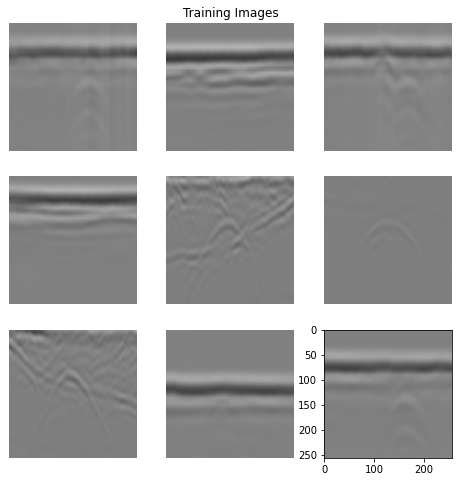

In [22]:
plot_images(train)

In [34]:
imgs = np.load('gpr.npz')

In [35]:
class GPR_data(Dataset):
    def __init__(self, npz_imgs):
        self.imgs = npz_imgs
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image = self.imgs[idx]
        return image

In [36]:
transpose_imgs = np.transpose(np.float32(imgs['arr_0']) , (0,3,1,2))
dset = GPR_data(transpose_imgs)
batch_size = 64
shuffle = True
dataloader = DataLoader(dataset = dset, batch_size = batch_size, shuffle=shuffle)

In [37]:
class Generator(Module):
    def __init__(self):
        super().__init__()
        
        self.gen = Sequential(
          ConvTranspose2d(in_channels = 100, out_channels = 512*4 , kernel_size = 4, stride = 1, padding = 0, bias = False),
          # the output from the above will be b_size ,512*4, 4,4
          BatchNorm2d(num_features = 512*4), # From an input of size (b_size, C, H, W), pick num_features = C
          ReLU(inplace = True),
            
          ConvTranspose2d(in_channels = 512*4, out_channels = 512*2 , kernel_size = 4, stride = 2, padding = 1, bias = False),
          # the output from the above will be b_size ,512*2, 8,8
          BatchNorm2d(num_features = 512*2), # From an input of size (b_size, C, H, W), pick num_features = C
          ReLU(inplace = True),
 
          ConvTranspose2d(in_channels = 512*2, out_channels = 512 , kernel_size = 4, stride = 2, padding = 1, bias = False),
          # the output from the above will be b_size ,512, 16,16
          BatchNorm2d(num_features = 512),
          ReLU(inplace = True),
 
          ConvTranspose2d(in_channels = 512, out_channels = 256 , kernel_size = 4, stride = 2, padding = 1, bias = False),
          # the output from the above will be b_size ,256, 32,32
          BatchNorm2d(num_features = 256),
          ReLU(inplace = True),
            
          ConvTranspose2d(in_channels = 256, out_channels = 128 , kernel_size = 4, stride = 2, padding = 1, bias = False),
          # the output from the above will be b_size ,128, 64,64
          BatchNorm2d(num_features = 128),
          ReLU(inplace = True),
            
          ConvTranspose2d(in_channels = 128, out_channels = 64 , kernel_size = 4, stride = 2, padding = 1, bias = False),
          # the output from the above will be b_size ,64, 128,128
          BatchNorm2d(num_features = 64),
          ReLU(inplace = True),
 
          ConvTranspose2d(in_channels = 64, out_channels = 3 , kernel_size = 4, stride = 2, padding = 1, bias = False),
          # the output from the above will be b_size ,3, 256,256
          Tanh()
         
        )

    def forward(self, input):
        return self.gen(input)

In [38]:
class Discriminator(Module):
    def __init__(self):
        super().__init__()
        
        self.dis = Sequential(
            
            Conv2d(in_channels = 3, out_channels = 16, kernel_size = 4, stride = 2, padding = 1, bias=False),
            # ouput from above layer is b_size, 64, 128, 128
            LeakyReLU(0.2, inplace=True),
            
            Conv2d(in_channels = 16, out_channels = 32, kernel_size = 4, stride = 2, padding = 1, bias=False),
            # ouput from above layer is b_size, 32, 64, 64
            LeakyReLU(0.2, inplace=True),
 
            Conv2d(in_channels = 32, out_channels = 32*2, kernel_size = 4, stride = 2, padding = 1, bias=False),
            # ouput from above layer is b_size, 32*2, 32, 32
            BatchNorm2d(32 * 2),
            LeakyReLU(0.2, inplace=True),
 
            Conv2d(in_channels = 32*2, out_channels = 32*4, kernel_size = 4, stride = 2, padding = 1, bias=False),
            # ouput from above layer is b_size, 32*4, 16, 16
            BatchNorm2d(32 * 4),
            LeakyReLU(0.2, inplace=True),
 
            Conv2d(in_channels = 32*4, out_channels = 32*8, kernel_size = 4, stride = 2, padding = 1, bias=False),
            # ouput from above layer is b_size, 256, 8, 8
            # NOTE: spatial size of this layer is 2x2, hence in the final layer, the kernel size must be 2 instead (or smaller than) 4
            BatchNorm2d(32 * 8),
            LeakyReLU(0.2, inplace=True),
            
            Conv2d(in_channels = 32*8, out_channels = 32*8, kernel_size = 4, stride = 2, padding = 1, bias=False),
            # ouput from above layer is b_size, 256, 4, 4
            # NOTE: spatial size of this layer is 2x2, hence in the final layer, the kernel size must be 2 instead (or smaller than) 4
            BatchNorm2d(32 * 8),
            LeakyReLU(0.2, inplace=True),
           
            Conv2d(in_channels = 32*8, out_channels = 32*16, kernel_size = 4, stride = 2, padding = 1, bias=False),
            # ouput from above layer is b_size, 512, 2, 2
            # NOTE: spatial size of this layer is 2x2, hence in the final layer, the kernel size must be 2 instead (or smaller than) 4
            BatchNorm2d(32 * 16),
            LeakyReLU(0.2, inplace=True),
            
            Conv2d(in_channels = 32*16, out_channels = 1, kernel_size = 2, stride = 2, padding = 0, bias=False),
            # ouput from above layer is b_size, 1, 1, 1
            Sigmoid()
        )
     
    def forward(self, input):
        return self.dis(input)

In [39]:
# creating gen and disc
netG = Generator().to(device)
netD = Discriminator().to(device)

In [40]:
def init_weights(m):
    if type(m) == ConvTranspose2d:
        nn.init.normal_(m.weight, 0.0, 0.02)
    elif type(m) == BatchNorm2d:
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [41]:
# initializing the weights
netD.apply(init_weights)
netG.apply(init_weights)

Generator(
  (gen): Sequential(
    (0): ConvTranspose2d(100, 2048, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Bat

In [42]:
# Setting up otimizers for both Generator and Discriminator
 
opt_D = optim.Adam(netD.parameters(), lr = 0.0002, betas= (0.5, 0.999))
opt_G = optim.Adam(netG.parameters(), lr = 0.0002, betas= (0.5, 0.999))

In [43]:
# Setting up the loss function - BCELoss (to check how far the predicted value is from real value)
 
loss = BCELoss()

tensor(0.1269, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2668, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(1.6688, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


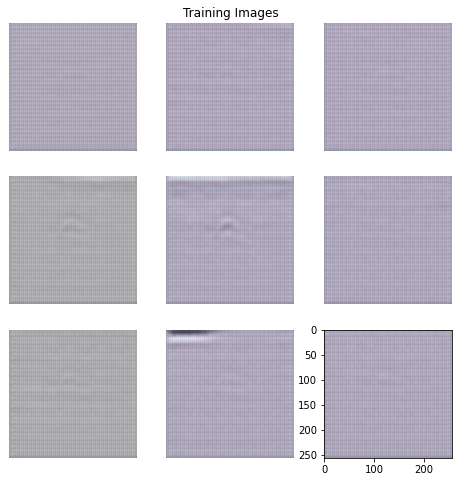

********************
 Epoch 100 and iteration 0 
tensor(0.0034, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0067, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(5.1064, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


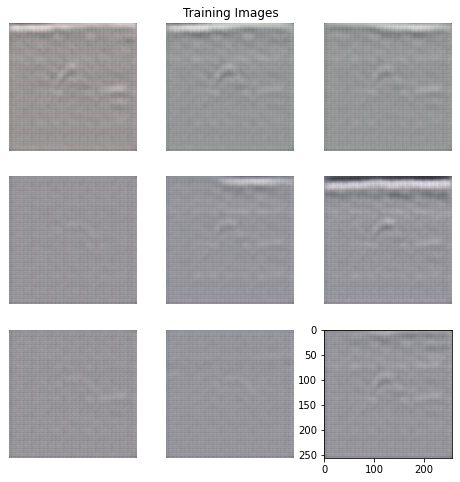

********************
 Epoch 200 and iteration 0 
tensor(0.5193, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0060, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(5.7338, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


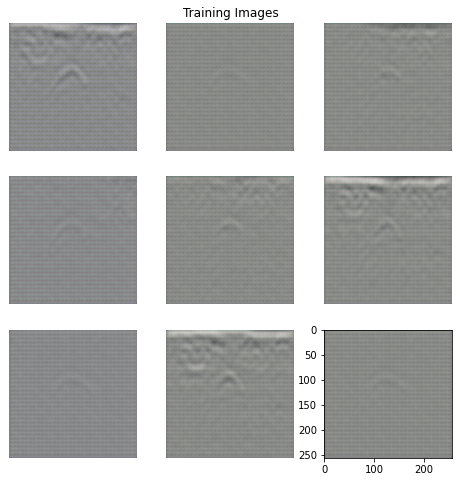

********************
 Epoch 300 and iteration 0 
tensor(0.0117, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1830, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(4.9892, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


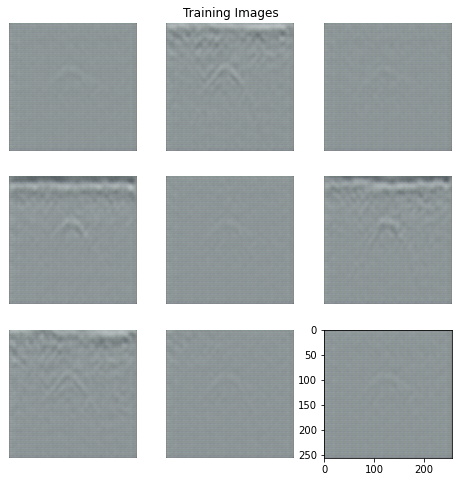

********************
 Epoch 400 and iteration 0 
tensor(0.0218, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0341, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(5.0973, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


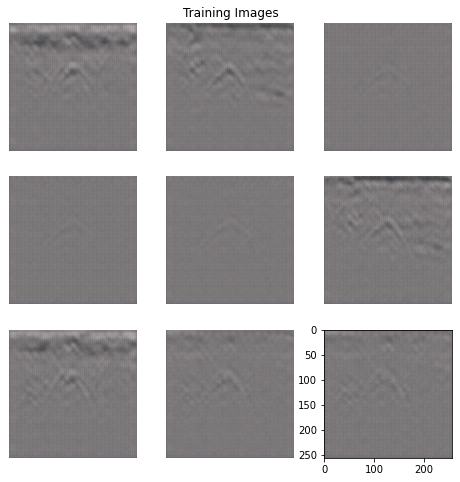

********************
 Epoch 500 and iteration 0 
tensor(0.0066, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0009, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(7.3594, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


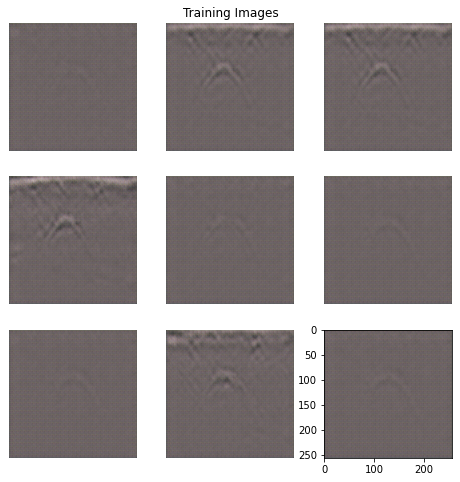

********************
 Epoch 600 and iteration 0 
tensor(0.0017, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0096, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(5.4563, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


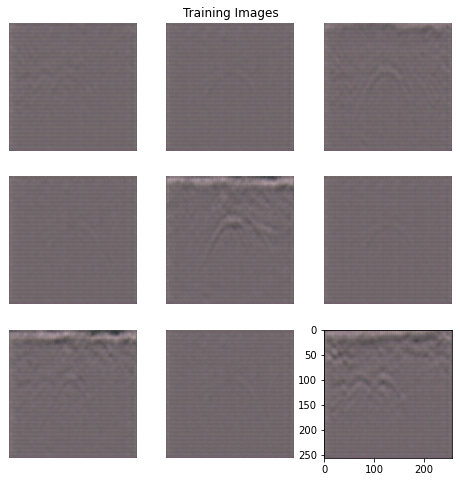

********************
 Epoch 700 and iteration 0 
tensor(0.0006, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0003, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(7.3268, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


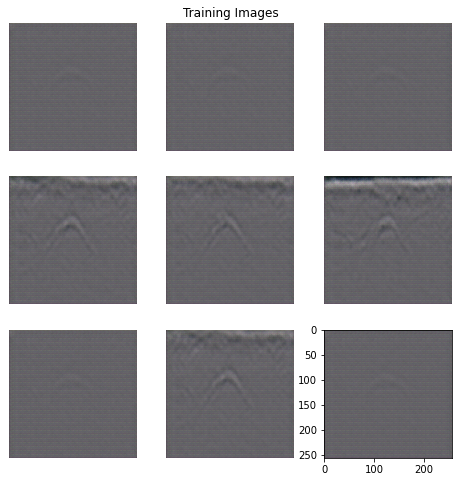

********************
 Epoch 800 and iteration 0 


In [ ]:
# TRAINING GANS
epochs = 1000
 
# going over the entire dataset 10 times
for e in range(epochs):
     
    # pick each batch b of input images: shape of each batch is (32, 3, 32, 32)
    for i, b in enumerate(dataloader):
 
        ##########################
        ## Update Discriminator ##
        ##########################
 
        # Loss on real images
         
        # clear the gradient
        opt_D.zero_grad() # set the gradients to 0 at start of each loop because gradients are accumulated on subsequent backward passes
        # compute the D model output
        yhat = netD(b.to(device)).view(-1) # view(-1) reshapes a 4-d tensor of shape (2,1,1,1) to 1-d tensor with 2 values only
        # specify target labels or true labels
        
        target = torch.ones(len(b), dtype=torch.float, device=device)
        # calculate loss
        loss_real = loss(yhat, target)
        if e!=0 and e% 100 == 0 and i==0:
            print(loss_real)
        # calculate gradients -  or rather accumulation of gradients on loss tensor
        loss_real.backward()
 
        # Loss on fake images
 
        # generate batch of fake images using G
        # Step1: creating noise to be fed as input to G
        noise = torch.randn(len(b), 100, 1, 1, device = device)
        # Step 2: feed noise to G to create a fake img (this will be reused when updating G)
        fake_img = netG(noise) 
 
        # compute D model output on fake images
        yhat = netD.cuda()(fake_img.detach()).view(-1) # .cuda() is essential because our input i.e. fake_img is on gpu but model isnt (runtimeError thrown); detach is imp: Basically, only track steps on your generator optimizer when training the generator, NOT the discriminator. 
        # specify target labels
        target = torch.zeros(len(b), dtype=torch.float, device=device)
        # calculate loss
        loss_fake = loss(yhat, target)
        if e!=0 and e% 100 == 0 and i==0:
            print(loss_fake)
        # calculate gradients
        loss_fake.backward()
        # total error on D
        loss_disc = loss_real + loss_fake
 
        # Update weights of D
        opt_D.step()
 
        ##########################
        #### Update Generator ####
        ##########################
 
        # clear gradient
        opt_G.zero_grad()
        # pass fake image through D
        yhat = netD.cuda()(fake_img).view(-1)
        # specify target variables - remember G wants D *to think* these are real images so label is 1
        target = torch.ones(len(b), dtype=torch.float, device=device)
        # calculate loss
        loss_gen = loss(yhat, target)
        if e!=0 and e% 100 == 0 and i==0:
            print(loss_gen)
        # calculate gradients
        loss_gen.backward()
        # update weights on G
        opt_G.step()
 
 
        ####################################
        #### Plot some Generator images ####
        ####################################
 
        # during every epoch, print images at every 10th iteration.
        if e!=0 and e% 100 == 0 and i==0:
            # convert the fake images from (b_size, 3, 32, 32) to (b_size, 32, 32, 3) for plotting 
            img_plot = np.transpose(fake_img.detach().cpu(), (0,2,3,1)) # .detach().cpu() is imp for copying fake_img tensor to host memory first
            plot_images(img_plot)
            print("********************")
            print(" Epoch %d and iteration %d " % (e, i))

In [147]:
noise = torch.randn(len(b), 100, 1, 1, device = device)
        # Step 2: feed noise to G to create a fake img (this will be reused when updating G)
fake_img = netG(noise) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


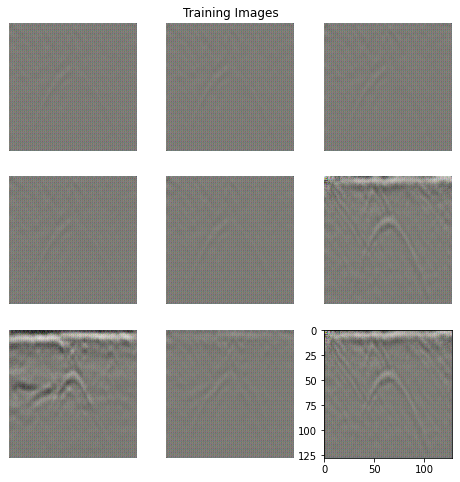

In [149]:
img_plot = np.transpose(fake_img.detach().cpu(), (0,2,3,1)) # .detach().cpu() is imp for copying fake_img tensor to host memory first
plot_images(img_plot, 3)